### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        if criterion == 'gini':
            self.G_function = (lambda l_c, l_s, r_c, r_s: 1 - (l_c ** 2 / l_s + r_c ** 2 / r_s).sum(axis=1))
            self.impurity = (lambda y: 1 - np.sum((np.bincount(y) / y.size) ** 2))
        elif criterion == 'entropy':
            self.G_function = (lambda l_c, l_s, r_c, r_s: - np.sum((l_c / l_c + r_c / r_s) * log(l_c / l_c + r_c / r_s)))
            self.impurity = (lambda y: - np.sum((np.bincount(y) / y.size) * (np.log(np.bincount(y) / y.size))))
        else:
            self.G_function = (lambda l_c, l_s, r_c, r_s: 1 - (np.max(l_c / (l_s + r_s), axis=1) + np.max(r_c / (l_s + r_s), axis=1)))
            self.impurity = (lambda y: 1 - np.max(np.bincount(y) / y.size))
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        sorted_idx = x.argsort()
        x, y = x[sorted_idx], y[sorted_idx]
        cut_size = np.int(self.min_samples_split / 2 - 1)
        if cut_size == 0:
            split_y = y
        else:
            split_y = y[cut_size:-cut_size]
        border = np.where(split_y[:-1] != split_y[1:])[0] + (cut_size + 1)
        if len(border) == 0:
            return np.inf, 0
        class_matrix = np.zeros((border.shape[0], self.num_class))
        class_matrix[np.arange(border.shape[0]), y[border - 1]] = 1
        l_c = np.cumsum(class_matrix * (border - np.append(np.array([cut_size]), border[:-1])).reshape(-1, 1), axis=0)
        r_c = np.bincount(y, minlength=self.num_class) - l_c
        l_s = border.reshape(l_c.shape[0], 1)
        r_s = y.shape[0] - l_s
        gs = self.G_function(l_c, l_s, r_c, r_s)
        return gs[np.argmin(gs)], (x[l_s[np.argmin(gs)][0] - 1] + x[l_s[np.argmin(gs)][0]]) / 2

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if (self.max_depth is not None and self.max_depth <= depth) or (y.shape[0] < self.min_samples_split) or (np.bincount(y).max() / y.shape[0] == 1):
            self.tree[node_id] = (self.__class__.LEAF_TYPE, np.bincount(y, minlength=self.num_class).argmax(), np.bincount(y, minlength=self.num_class)/y.size)
            return
        threshold = np.array([self.__find_threshold(x[:, f], y) for f in np.arange(x.shape[1])])
        l_x, r_x, l_y, r_y = self.__div_samples(x, y, np.arange(x.shape[1])[threshold[:, 0].argmin()], threshold[threshold[:, 0].argmin(), 1])
        if l_x.shape[0] == 0 or r_x.shape[0] == 0:
            self.tree[node_id] = (self.__class__.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y)/y.size)
            return
        self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, threshold[:, 0].argmin(), threshold[threshold[:, 0].argmin(), 1])
        self.__fit_node(l_x, l_y, node_id * 2 + 1, depth + 1)
        self.__fit_node(r_x, r_y, node_id * 2 + 2, depth + 1)
        self.feature_importances_[threshold[:, 0].argmin()] += (self.impurity(y) - threshold[:, 0].min())
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance():
        """
        Возвращает важность признаков
        """
       return self.feature_importances_


In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.8333333333333334

In [6]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8888888888888888

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [7]:
%time clf.fit(X_train, y_train)

CPU times: user 3.01 ms, sys: 331 µs, total: 3.34 ms
Wall time: 2.01 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                max_depth=None, max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, presort='deprecated',
                random_state=None, splitter='best')

In [8]:
%time my_clf.fit(X_train, y_train)

CPU times: user 20.2 ms, sys: 918 µs, total: 21.1 ms
Wall time: 19.8 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [9]:
X_raw = pd.read_csv('../input/speed-dating-experiment/Speed Dating Data.csv', encoding='ISO-8859-1')
X_raw.dropna(axis=0, subset=['match'], inplace=True)
y = X_raw.match
X_raw.drop(['id', 'idg', 'iid', 'pid', 'partner', 'match', 'dec', 'dec_o', 'you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3'], axis=1, inplace=True)
X = X_raw.select_dtypes(exclude=['object']).fillna(0)
col = X.columns
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

In [10]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='gini')
my_clf.fit(X_train.to_numpy(), y_train.to_numpy())
print('gini:', accuracy_score(y_pred=my_clf.predict(X_val.to_numpy()), y_true=y_val.to_numpy()))
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='entropy')
my_clf.fit(X_train.to_numpy(), y_train.to_numpy())
print('entropy:', accuracy_score(y_pred=my_clf.predict(X_val.to_numpy()), y_true=y_val.to_numpy()))
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='misclass')
my_clf.fit(X_train.to_numpy(), y_train.to_numpy())
print('misclass:', accuracy_score(y_pred=my_clf.predict(X_val.to_numpy()), y_true=y_val.to_numpy()))


gini: 0.8532219570405728
entropy: 0.8484486873508353
misclass: 0.8353221957040573


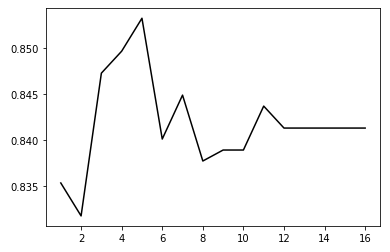

In [11]:
l = []
for a in range(1, 17):
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=a, criterion='gini')
    my_clf.fit(X_train.to_numpy(), y_train.to_numpy())
    l.append(accuracy_score(y_pred=my_clf.predict(X_val.to_numpy()), y_true=y_val.to_numpy()))
plt.plot(range(1, 17), l, 'k-')

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

